In [1]:
import os
import random
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
import statsmodels.formula.api as smf

# First task

In [2]:
CURRENT_PATH = Path(os.path.abspath(""))
CURRENT_PATH = CURRENT_PATH.resolve()
TURNS_PATH = CURRENT_PATH.parent.joinpath(
    "data", "annotations", "parsed", "aggregated_Turns_RAFT.csv"
)
FOCUS_PATH = CURRENT_PATH.parent.joinpath(
    "data", "annotations", "parsed", "aggregated_Focus_RAFT.csv"
)

# it contains only the values for RAFT
data = pd.read_csv(TURNS_PATH, header=0, index_col=False)
data

# map the session specific position, to generic labels
MAP_TO_POSITION = {
    "SESS001_tl": "P1", "SESS001_bl":"P2", "SESS001_br":"P3",
    "SESS002_tl": "P1", "SESS002_bl_tr":"P2", "SESS002_br_bc":"P3",
    "SESS003_tl": "P1", "SESS003_tr":"P2", "SESS003_bc":"P3",
    "SESS004_tl": "P1", "SESS004_tr":"P2", "SESS004_bc":"P3",
    "SESS005_tl": "P1", "SESS005_bl":"P2", "SESS005_br":"P3",
    "SESS006_tl": "P1", "SESS006_tr":"P2", "SESS006_bc":"P3",
    "SESS009_tl": "P1", "SESS009_tr":"P2", "SESS009_bc":"P3",
}

# note that sometime the order is not clear (for simplicity here only the combinations present in the dataset are report, only tl-br, not also br-tl)
MAP_SPEAKER_TO_POSITION = {
    "SESS001": {"tl": "P1", "bl":"P2", "br":"P3", "bl-tl":"P1-P2", "br-tl":"P1-P3", "bl-br":"P2-P3", "tl-bl-br":"P1-P2-P3"},
    "SESS002": {"tl": "P1", "bl_tr":"P2", "br_bc":"P3", "tl-bl_tr":"P1-P2", "tl-br_bc":"P1-P3", "bl_tr-br_bc":"P2-P3", "tl-bl_tr-br_bc":"P1-P2-P3"},
    "SESS003": {"tl": "P1", "tr":"P2", "bc":"P3", "tl-bc": "P1-P3", "tr-bc": "P2-P3", "tl-tr":"P1-P2"},
    "SESS004": {"tl": "P1", "tr":"P2", "bc":"P3", "tl-bc": "P1-P3", "tl-tr": "P1-P2", "tl-tr-bc": "P1-P2-P3", "tr-bc": "P2-P3"},
    "SESS005": {"tl": "P1", "bl":"P2", "br":"P3", "tl-bl": "P1-P2", "tl-br": "P1-P3", "bl-br": "P2-P3"},
    "SESS006": {"tl": "P1", "tr":"P2", "bc":"P3", "tr-bc": "P2-P3", "tl-tr": "P1-P2", "tl-bc": "P1-P3", "tl-tr-bc": "P1-P2-P3"},
    "SESS009": {"tl": "P1", "tr":"P2", "bc":"P3", "tr-bc": "P2-P3", "tl-bc": "P1-P3", "tl-tr": "P1-P2"},
}


data["Position"] = data["Person"].replace(MAP_TO_POSITION)
# remove not useful columns (only RAFT method and Position used instead of Person)
data = data.drop(columns = ["Method", "Person"])

# for each session, map the speaker to the position
data_grouped = data.groupby("Session")
for session, data_session in data_grouped:
    data.loc[data["Session"] == session] = data_session.replace(MAP_SPEAKER_TO_POSITION[session])

data

,Session,Start,End,SpeakerThatInterval,AVG_Optical_Flow_Person,Position
0,SESS001,0.00,0.24,SILENCE,0.027642,P2
1,SESS001,0.00,0.24,SILENCE,0.033523,P1
2,SESS001,0.00,0.24,SILENCE,0.020960,P3
3,SESS001,0.24,1.90,P2,0.919160,P2
4,SESS001,0.24,1.90,P2,0.518752,P1
...,...,...,...,...,...,...
12229,SESS009,531.07,531.72,SILENCE,1.087214,P1
12230,SESS009,531.07,531.72,SILENCE,0.205947,P2
12231,SESS009,531.72,533.40,P3,2.517215,P3
12232,SESS009,531.72,533.40,P3,0.512621,P1


In [3]:
input_data = data.pivot(index = ["Session", "Start", "End", "SpeakerThatInterval"], columns="Position", values="AVG_Optical_Flow_Person").reset_index()
# drop columns no longer useful
input_data.columns.name = None  # remove index name
input_data = input_data.rename(columns= {"SpeakerThatInterval": "Label"})
input_data = input_data.dropna(axis = "index", how = "any", ignore_index=True) # remove the rows with Nan (no avg optical flow for that intervals)

without_label = input_data[["P1", "P2", "P3"]]
input_data[["Min", "Middle", "Max"]] = np.argsort(without_label, axis = 1)
new_data = []
for row in input_data.to_numpy().tolist():
    if row[3] != "SILENCE":
        # get new position using the previous argsort
        new_label = []
        for pos in row[3].split("-"):
            if pos == "P1":
                new_position_label = row[-3]
            elif pos == "P2":
                new_position_label = row[-2]
            elif pos == "P3":
                new_position_label = row[-1]

            # add the label
            new_label += [["Min", "Middle", "Max"][new_position_label]]

        # sort to be use the same order for all the rows
        row[3] = "_".join(sorted(new_label, reverse = True))

    # use the argsort indexes to reorder
    row[-3], row[-2], row[-1] =  row[4+row[-3]], row[4+row[-2]], row[4+row[-1]]
    new_data.append(row)

old_label = input_data["Label"].copy()
print("Problems: ", old_label.isna().sum())
print("Problems: ", (old_label == "NaN").sum())
input_data = pd.DataFrame(np.array(new_data), columns = input_data.columns)
# input_data["OldLabel"] = old_label # just to check the computations
input_data = input_data.drop(columns = ["P1", "P2", "P3"])
print(input_data["Label"].unique())
input_data

Problems:  0
Problems:  0
['SILENCE' 'Middle' 'Min' 'Min_Max' 'Max' 'Min_Middle' 'Middle_Max'
 'Min_Middle_Max']


,Session,Start,End,Label,Min,Middle,Max
0,SESS001,0.0,0.24,SILENCE,0.020960381,0.02764167,0.033522904
1,SESS001,0.24,1.9,Middle,0.5187516125,0.9191603675,1.81655
2,SESS001,1.9,3.88,SILENCE,0.4060471599999999,0.9854504679999998,5.7989053
3,SESS001,3.88,4.18,Min,0.1590437,1.4224672,15.010719
4,SESS001,4.18,4.7,Min_Max,0.23470016,0.8377061,11.856337
...,...,...,...,...,...,...,...
3685,SESS009,524.6,524.785,Middle,0.1769679,1.0026175,1.5177833
3686,SESS009,524.785,530.36,SILENCE,0.1005453346428571,0.7645617778571429,1.4944491635714283
3687,SESS009,530.36,531.07,Max,0.045454875,0.11502768,0.42550093
3688,SESS009,531.07,531.72,SILENCE,0.2059473299999999,0.9052261,1.08721415


Each sample is an interval, but they do not all have the same duration. In this cell we compute the percentage of time each label is actually talking in the meetings. \\


**NOTE**: the person moving the most is more often the person talking, then there is second person moving the most and finally the person moving the least. It is what we have hypothesized at the beginning.

In [4]:
input_data = input_data.astype({"Start": np.float32, "End": np.float32})
input_data["Duration"] = input_data["End"]-input_data["Start"]
temp_data = input_data[["Label", "Duration"]]
# time percentage for each label
weight_per_label = temp_data.groupby("Label").sum() / temp_data.groupby("Label").sum().sum()
weight_per_label

,Duration
Label,
Max,0.256158
Middle,0.207294
Middle_Max,0.014231
Min,0.189319
Min_Max,0.012504
Min_Middle,0.011140
Min_Middle_Max,0.000434
SILENCE,0.308919


Most of the labels are silence, but they over represent the time silence is present in an audio.

In [5]:
input_data.groupby("Label")["Label"].describe()
print(f"Majority classes proportion {(input_data['Label']=='SILENCE').sum() / input_data.shape[0]:.3f}")

Majority classes proportion 0.410


## Classification

In [6]:
input_data_c = input_data.drop(columns = ["Start", "End"])
label_encoder = LabelEncoder()
input_data_c["Label"] = label_encoder.fit_transform(input_data_c["Label"])

# extract features and label
X = input_data_c[["Min", "Middle", "Max"]]
y = input_data_c[["Label", "Duration"]]

# Use SESS009 only for test
X_test_sess_9, y_test_sess_9 = X[input_data_c["Session"] == "SESS009"], y[input_data_c["Session"] == "SESS009"]
X, y = X[input_data_c["Session"] != "SESS009"], y[input_data_c["Session"] != "SESS009"]


# Split the remaining meetings in training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y["Label"]) # stratified because there is a heavy imbalance

print(X_train.shape, X_test.shape, X_test_sess_9.shape)

(3021, 3) (336, 3) (333, 3)


Since the dataset is heavily unbalanced, we resample the training set in order to obtain better classifiers.


### Decision tree training

d:\Personale\Programmi\Miniconda\envs\test\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Decision Tree Best Parameters: {'class_weight': None, 'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 2}
Decision Tree Best Cross-Validation Score: 0.14


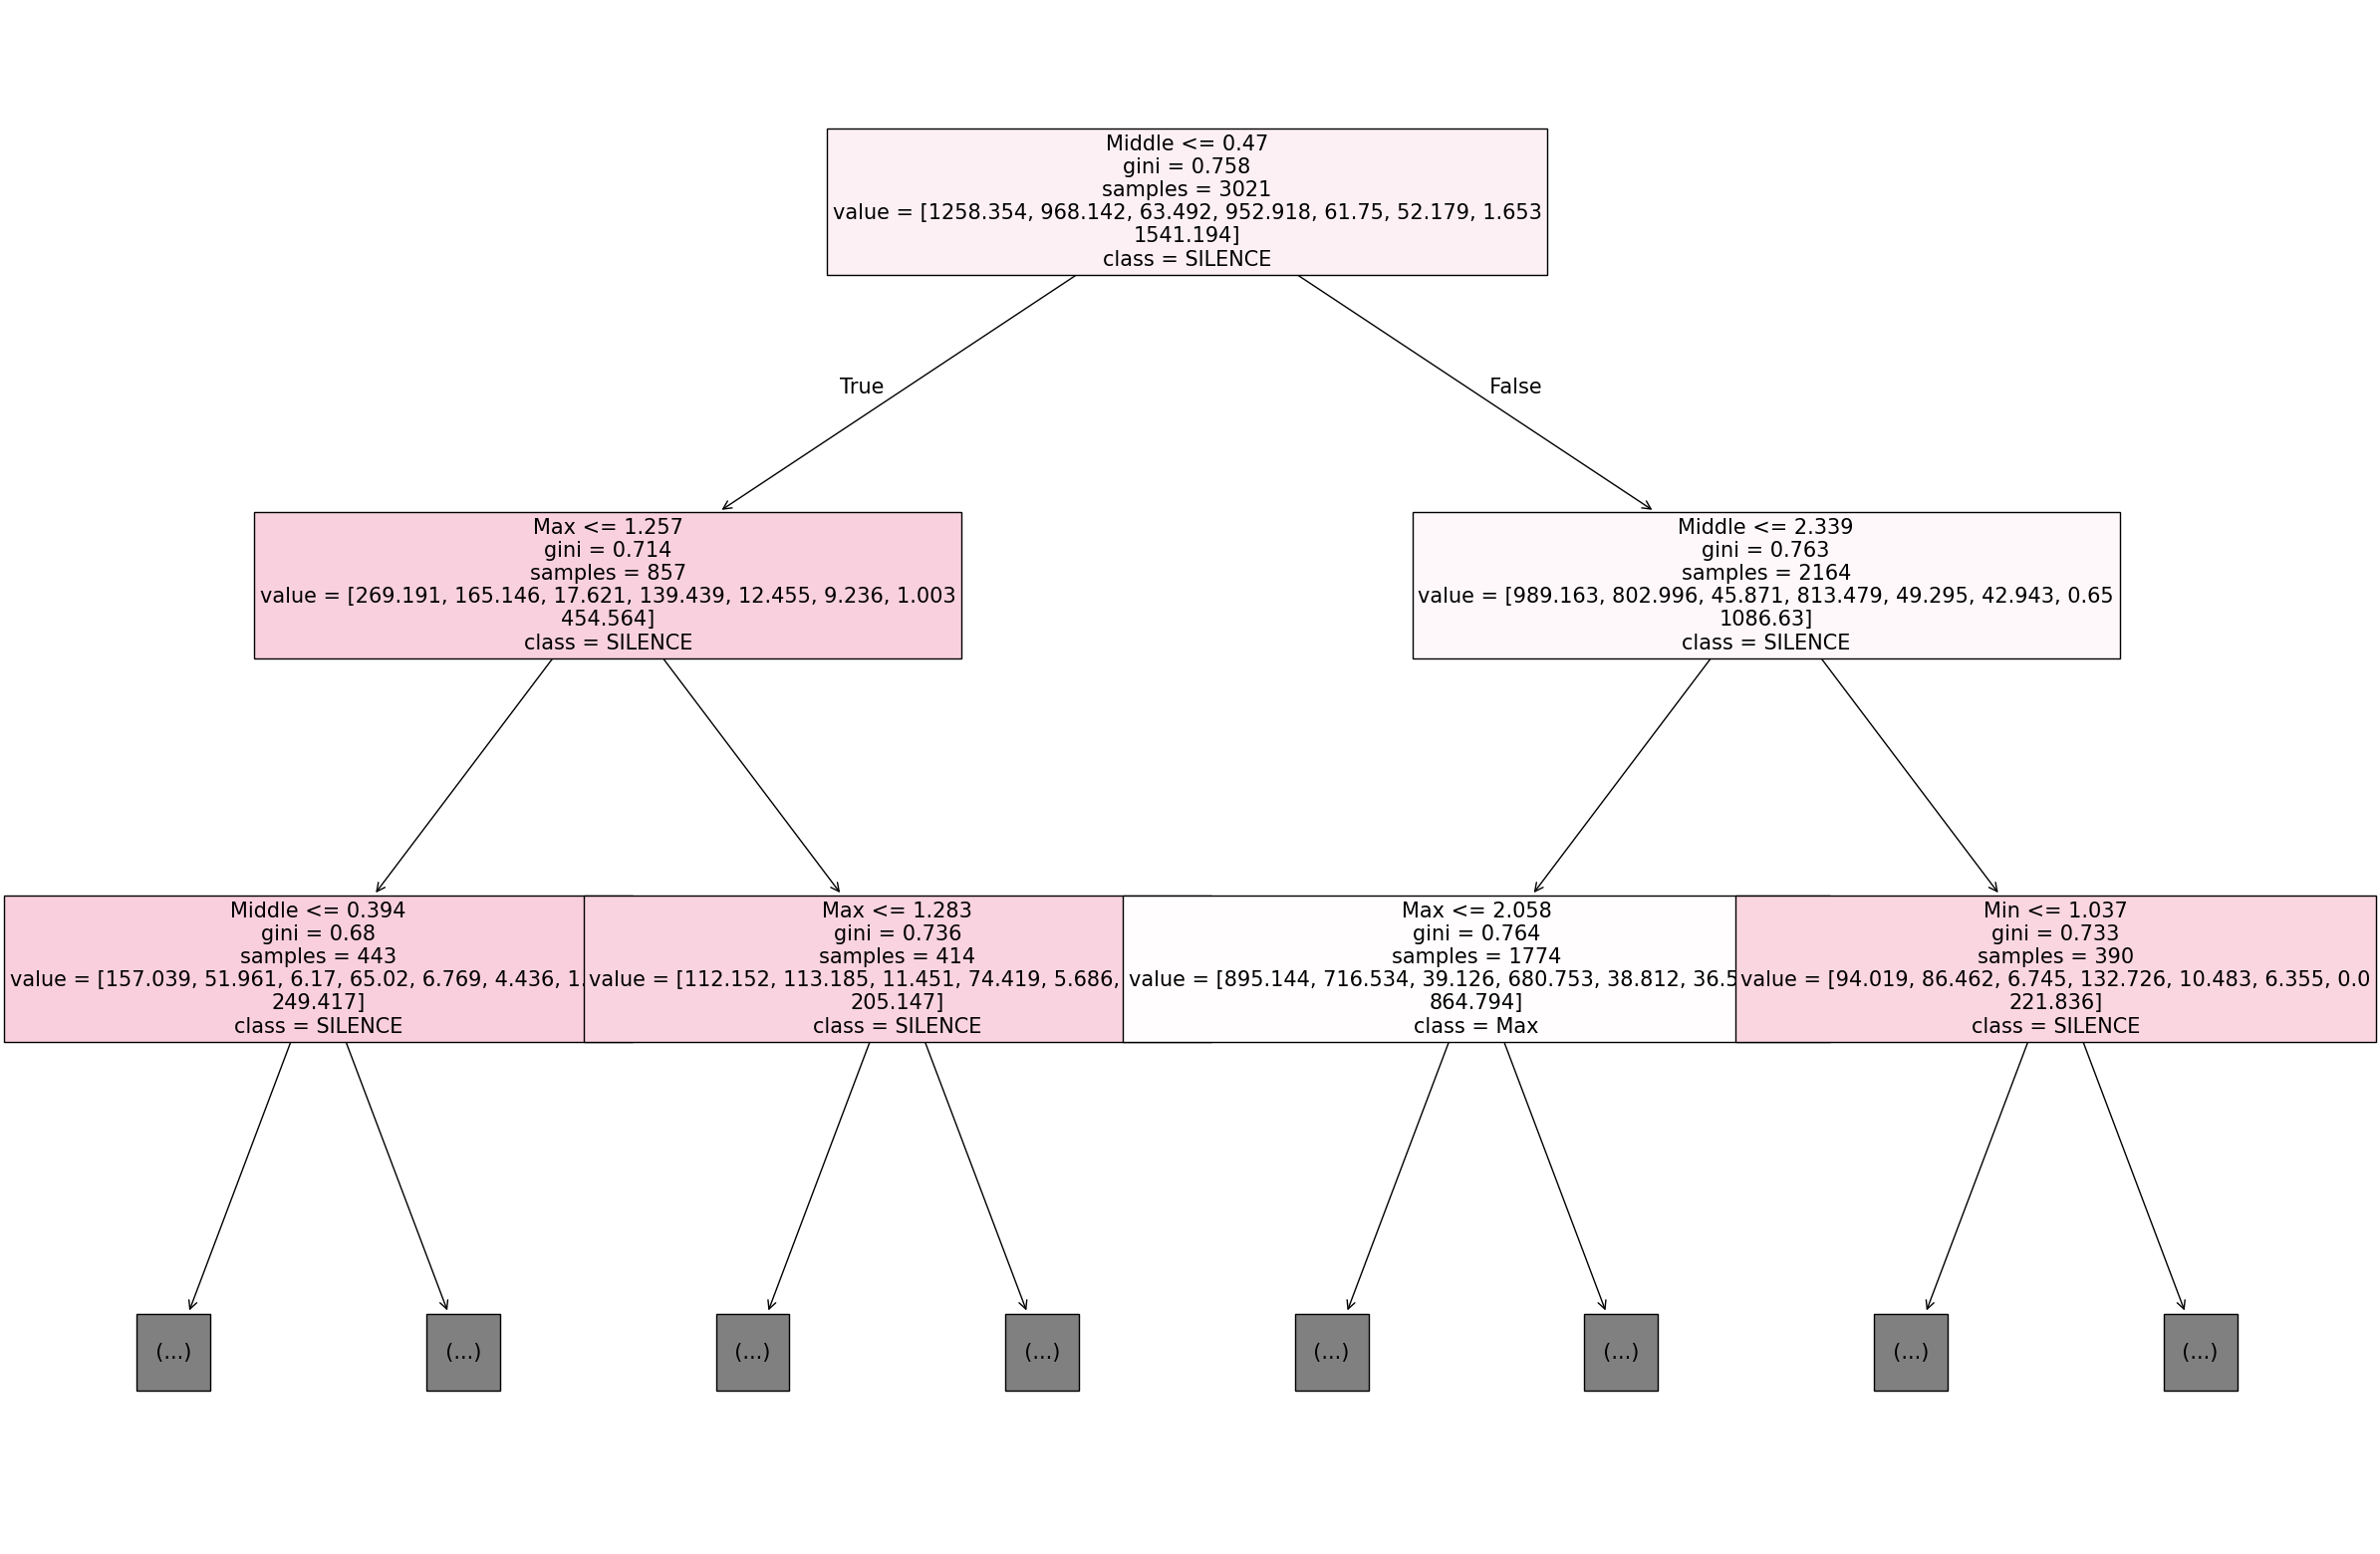

In [7]:
# Parameter grid for Decision Tree
param_grid_dt = {
    'max_depth': [1, 3, 5, 8, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ["balanced", None]
}

random_seed = 54

np.random.seed(random_seed)
random.seed(random_seed)


# train the model
dt = DecisionTreeClassifier(random_state=42)

grid_search_dt = GridSearchCV(estimator=dt, param_grid=param_grid_dt, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search_dt.fit(X_train, y_train["Label"], sample_weight= y_train["Duration"]) # the duration is the weight of the error of each sample

best_params_dt = grid_search_dt.best_params_
best_score_dt = grid_search_dt.best_score_
print(f"Decision Tree Best Parameters: {best_params_dt}")
print(f"Decision Tree Best Cross-Validation Score: {best_score_dt:.2f}")
best_dt = grid_search_dt.best_estimator_


# Visualize the decision tree
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(30, 20)
plot_tree(best_dt, filled=True, ax = ax, max_depth=2, fontsize=15, label = "all", class_names=label_encoder.classes_, feature_names=["Min", "Middle", "Max"])
plt.show()

### Random Forest

In [8]:
param_grid_rf = {
    'max_depth': [1, 3, 5, 12, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, "balanced"]
}
rf = RandomForestClassifier(random_state=42)
grid_search_rf_optimized = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search_rf_optimized.fit(X_train, y_train["Label"], sample_weight= y_train["Duration"]) # the duration is the weight of the error of each sample

best_params_rf_optimized = grid_search_rf_optimized.best_params_
best_score_rf_optimized = grid_search_rf_optimized.best_score_
print(f"Random Forest Best Parameters (Optimized): {best_params_rf_optimized}")
print(f"Random Forest Best Cross-Validation Score (Optimized): {best_score_rf_optimized:.2f}")

best_rf_optimized = grid_search_rf_optimized.best_estimator_

d:\Personale\Programmi\Miniconda\envs\test\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Random Forest Best Parameters (Optimized): {'class_weight': 'balanced', 'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 2}
Random Forest Best Cross-Validation Score (Optimized): 0.14


### SVM Training

In [9]:
param_grid_svm_optimized = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf'],
    'gamma': ['scale'],
    'class_weight':  [None, "balanced"]
}

svm = SVC(random_state=42) # handles also the less represented classes
grid_search_svm_optimized = GridSearchCV(estimator=svm, param_grid=param_grid_svm_optimized, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search_svm_optimized.fit(X_train, y_train["Label"], sample_weight= y_train["Duration"]) # the duration is the weight of the error of each sample

best_params_svm_optimized = grid_search_svm_optimized.best_params_
best_score_svm_optimized = grid_search_svm_optimized.best_score_
print(f"SVM Best Parameters (Optimized): {best_params_svm_optimized}")
print(f"SVM Best Cross-Validation Score (Optimized): {best_score_svm_optimized:.2f}")

best_svm_optimized = grid_search_svm_optimized.best_estimator_

d:\Personale\Programmi\Miniconda\envs\test\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


SVM Best Parameters (Optimized): {'C': 10, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf'}
SVM Best Cross-Validation Score (Optimized): 0.09


### Evaluation

The true accuracy depends on the duration of the intervals. Making wrong prediction of a long interval should be penalized more heavily. We use the duration of each interval as a weight for computing the errors. \\
This addresses the problem that 41% of the intervals are SILENCE, but only 30% of the audio is covered by it.

In [10]:
y_pred_dt = best_dt.predict(X_test)
y_pred_dt_sess_9 = best_dt.predict(X_test_sess_9)
y_pred_dt_silence = label_encoder.transform(["SILENCE"] * y_pred_dt.shape[0])
y_pred_dt_sess_9_silence = label_encoder.transform(["SILENCE"] * y_pred_dt_sess_9.shape[0])
y_pred_svm = best_svm_optimized.predict(X_test)
y_pred_svm_sess_9 = best_svm_optimized.predict(X_test_sess_9)
y_pred_rf = best_rf_optimized.predict(X_test)
y_pred_rf_sess_9 = best_rf_optimized.predict(X_test_sess_9)


print("\n\n\n")
print("****** Results on the same meetings ******")
print("\n\n\n")
print("Baseline (only 'SILENCE')")
print(classification_report(y_test["Label"], y_pred_dt_silence, zero_division = np.nan, sample_weight=y_test["Duration"]))
print("\n")
print("Decision Tree")
print("\n")
print(classification_report(y_test["Label"], y_pred_dt, zero_division = np.nan, sample_weight=y_test["Duration"]))
print("\n")
print("SVM")
print("\n")
print(classification_report(y_test["Label"], y_pred_svm, zero_division = np.nan, sample_weight=y_test["Duration"]))
print("\n")
print("Random Forest")
print("\n")
print(classification_report(y_test["Label"], y_pred_rf, zero_division = np.nan, sample_weight=y_test["Duration"]))
print("\n\n\n")
print("****** Results on the different meeting ******")
print("\n\n\n")
print("Baseline (only 'SILENCE')")
print(classification_report(y_test_sess_9["Label"], y_pred_dt_sess_9_silence, zero_division = np.nan, sample_weight=y_test_sess_9["Duration"]))
print("\n")
print("Decision Tree")
print("\n")
print(classification_report(y_test_sess_9["Label"], y_pred_dt_sess_9, zero_division = np.nan, sample_weight=y_test_sess_9["Duration"]))
print("\n")
print("SVM")
print("\n")
print(classification_report(y_test_sess_9["Label"], y_pred_svm_sess_9, zero_division = np.nan, sample_weight=y_test_sess_9["Duration"]))
print("\n")
print("Random Forest")
print("\n")
print(classification_report(y_test_sess_9["Label"], y_pred_rf_sess_9, zero_division = np.nan, sample_weight=y_test_sess_9["Duration"]))





****** Results on the same meetings ******




Baseline (only 'SILENCE')
              precision    recall  f1-score   support

           0        nan      0.00      0.00 132.34092712402344
           1        nan      0.00      0.00 112.62685787677765
           2        nan      0.00      0.00 11.96807861328125
           3        nan      0.00      0.00 104.2607489824295
           4        nan      0.00      0.00 7.7269744873046875
           5        nan      0.00      0.00 6.1479949951171875
           6        nan      0.00      0.00 0.9300003051757812
           7       0.28      1.00      0.44 146.5207233428955

    accuracy                           0.28 522.522305727005
   macro avg       0.28      0.12      0.05 522.522305727005
weighted avg       0.28      0.28      0.12 522.522305727005



Decision Tree


              precision    recall  f1-score   support

           0       0.43      0.54      0.48 132.34092712402344
           1       0.32      0.22      0.26 11

### Filter silence

In [11]:
# Filter the silence labels
label_silence = label_encoder.transform(["SILENCE"])[0]
X_train = X_train[y_train["Label"] != label_silence]
y_train = y_train[y_train["Label"] != label_silence]

param_grid_rf = {
    'max_depth': [1, 3, 5, 12, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, "balanced"]
}
rf = RandomForestClassifier(random_state=42)
grid_search_rf_optimized = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search_rf_optimized.fit(X_train, y_train["Label"], sample_weight= y_train["Duration"]) # the duration is the weight of the error of each sample


best_params_rf_optimized = grid_search_rf_optimized.best_params_
best_score_rf_optimized = grid_search_rf_optimized.best_score_
print(f"Random Forest Best Parameters (Optimized): {best_params_rf_optimized}")
print(f"Random Forest Best Cross-Validation Score (Optimized): {best_score_rf_optimized:.2f}")

best_rf_optimized = grid_search_rf_optimized.best_estimator_

d:\Personale\Programmi\Miniconda\envs\test\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Random Forest Best Parameters (Optimized): {'class_weight': 'balanced', 'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 5}
Random Forest Best Cross-Validation Score (Optimized): 0.15


In [12]:
# Filter the silence labels
X_test = X_test[y_test["Label"] != label_silence]
y_test = y_test[y_test["Label"] != label_silence]
X_test_sess_9 = X_test_sess_9[y_test_sess_9["Label"] != label_silence]
y_test_sess_9 = y_test_sess_9[y_test_sess_9["Label"] != label_silence]

# second most present label is Max after silence
y_pred_silence = label_encoder.transform(["Max"] * y_test.shape[0])
y_pred_sess_9_silence = label_encoder.transform(["Max"] * y_test_sess_9.shape[0])
y_pred_rf = best_rf_optimized.predict(X_test)
y_pred_rf_sess_9 = best_rf_optimized.predict(X_test_sess_9)


print("\n\n\n")
print("****** Results on the same meetings ******")
print("\n\n\n")
print("Baseline (only 'Max')")
print(classification_report(y_test["Label"], y_pred_silence, zero_division = np.nan, sample_weight=y_test["Duration"]))
print("\n")
print("Random Forest")
print("\n")
print(classification_report(y_test["Label"], y_pred_rf, zero_division = np.nan, sample_weight=y_test["Duration"]))
print("\n\n\n")
print("****** Results on the different meeting ******")
print("\n\n\n")
print("Baseline (only 'Max')")
print(classification_report(y_test_sess_9["Label"], y_pred_sess_9_silence, zero_division = np.nan, sample_weight=y_test_sess_9["Duration"]))
print("\n")
print("Random Forest")
print("\n")
print(classification_report(y_test_sess_9["Label"], y_pred_rf_sess_9, zero_division = np.nan, sample_weight=y_test_sess_9["Duration"]))





****** Results on the same meetings ******




Baseline (only 'Max')
              precision    recall  f1-score   support

           0       0.35      1.00      0.52 132.34092712402344
           1        nan      0.00      0.00 112.62685787677765
           2        nan      0.00      0.00 11.96807861328125
           3        nan      0.00      0.00 104.2607489824295
           4        nan      0.00      0.00 7.7269744873046875
           5        nan      0.00      0.00 6.1479949951171875
           6        nan      0.00      0.00 0.9300003051757812

    accuracy                           0.35 376.0015823841095
   macro avg       0.35      0.14      0.07 376.0015823841095
weighted avg       0.35      0.35      0.18 376.0015823841095



Random Forest


              precision    recall  f1-score   support

           0       0.39      0.49      0.44 132.34092712402344
           1       0.47      0.52      0.49 112.62685787677765
           2        nan      0.00      0.00 11

## Prediction

In [13]:
# join the start with end of the same meeting to get the predictions (keep only the rows that have a next interval)
input_data_p = input_data.merge(input_data, left_on = ["Session", "End"], right_on = ["Session", "Start"], how="inner", validate = "one_to_one", suffixes=["", "_next_interval"])
input_data_p = input_data_p.drop(columns = ["Duration", "Start", "End", "Label", "Start_next_interval", "End_next_interval", "Min_next_interval", "Middle_next_interval", "Max_next_interval"])
input_data_p = input_data_p.rename(columns = {"Label_next_interval": "Label", "Duration_next_interval": "Duration"})
input_data_p

,Session,Min,Middle,Max,Label,Duration
0,SESS001,0.020960381,0.02764167,0.033522904,Middle,1.660000
1,SESS001,0.5187516125,0.9191603675,1.81655,SILENCE,1.980000
2,SESS001,0.4060471599999999,0.9854504679999998,5.7989053,Min,0.300000
3,SESS001,0.1590437,1.4224672,15.010719,Min_Max,0.520000
4,SESS001,0.06075293,0.138118,7.7102532,Middle,0.610000
...,...,...,...,...,...,...
3341,SESS009,0.17172562,0.81060636,0.93557936,Middle,0.184998
3342,SESS009,0.1769679,1.0026175,1.5177833,SILENCE,5.575012
3343,SESS009,0.1005453346428571,0.7645617778571429,1.4944491635714283,Max,0.710022
3344,SESS009,0.045454875,0.11502768,0.42550093,SILENCE,0.649963


In [14]:
label_encoder = LabelEncoder()
input_data_p["Label"] = label_encoder.fit_transform(input_data_p["Label"])

# extract features and label
X = input_data_p[["Min", "Middle", "Max"]]
y = input_data_p[["Label", "Duration"]]

# Use SESS009 only for test
X_test_sess_9, y_test_sess_9 = X[input_data_p["Session"] == "SESS009"], y[input_data_p["Session"] == "SESS009"]
X, y = X[input_data_p["Session"] != "SESS009"], y[input_data_p["Session"] != "SESS009"]


# Split the remaining meetings in training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y["Label"]) # stratified because there is a heavy imbalance

print(X_train.shape, X_test.shape, X_test_sess_9.shape)
X_train

(2754, 3) (307, 3) (285, 3)


,Min,Middle,Max
2409,0.12495005,0.3907386,1.134394665
769,0.1294699949615384,0.8883311008846154,5.153894210769232
2015,0.3996112,0.5263768,0.97547954
1263,0.9879589,0.99035735,2.9941463500000003
1215,1.3638970333333331,3.190555933333333,6.6291008
...,...,...,...
1905,0.8285290700000001,1.0713130193333331,2.7586785000000003
283,0.7642381606666667,0.828278247,3.0949953794444447
652,0.57468677,0.5827119,4.992739
978,0.7929414933333333,1.4105774000000002,6.765440066666667


### Random Forest

We train a Random Forest model because it is the model that delivered the best results in the classification task.

In [15]:
param_grid_rf = {
    'max_depth': [1, 3, 5, 12, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, "balanced"]
}
rf = RandomForestClassifier(random_state=42)
grid_search_rf_optimized = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search_rf_optimized.fit(X_train, y_train["Label"], sample_weight= y_train["Duration"]) # the duration is the weight of the error of each sample

best_params_rf_optimized = grid_search_rf_optimized.best_params_
best_score_rf_optimized = grid_search_rf_optimized.best_score_
print(f"Random Forest Best Parameters (Optimized): {best_params_rf_optimized}")
print(f"Random Forest Best Cross-Validation Score (Optimized): {best_score_rf_optimized:.2f}")

best_rf_optimized = grid_search_rf_optimized.best_estimator_

d:\Personale\Programmi\Miniconda\envs\test\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Random Forest Best Parameters (Optimized): {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2}
Random Forest Best Cross-Validation Score (Optimized): 0.14


In [16]:
y_pred_rf = best_rf_optimized.predict(X_test)
y_pred_rf_sess_9 = best_rf_optimized.predict(X_test_sess_9)
y_pred_silence = label_encoder.transform(["SILENCE"] * y_pred_rf.shape[0])
y_pred_sess_9_silence = label_encoder.transform(["SILENCE"] * y_pred_rf_sess_9.shape[0])


print("\n\n\n")
print("****** Results on the same meetings ******")
print("\n\n\n")
print("Baseline (only 'SILENCE')")
print(classification_report(y_test["Label"], y_pred_silence, zero_division = np.nan, sample_weight=y_test["Duration"]))
print("\n")
print("Random Forest")
print("\n")
print(classification_report(y_test["Label"], y_pred_rf, zero_division = np.nan, sample_weight=y_test["Duration"]))
print("\n\n\n")
print("****** Results on the different meeting ******")
print("\n\n\n")
print("Baseline (only 'SILENCE')")
print(classification_report(y_test_sess_9["Label"], y_pred_sess_9_silence, zero_division = np.nan, sample_weight=y_test_sess_9["Duration"]))
print("\n")
print("Random Forest")
print("\n")
print(classification_report(y_test_sess_9["Label"], y_pred_rf_sess_9, zero_division = np.nan, sample_weight=y_test_sess_9["Duration"]))





****** Results on the same meetings ******




Baseline (only 'SILENCE')
              precision    recall  f1-score   support

           0        nan      0.00      0.00 135.0959701538086
           1        nan      0.00      0.00 113.02809810638428
           2        nan      0.00      0.00 5.290130615234375
           3        nan      0.00      0.00 88.7957878112793
           4        nan      0.00      0.00 3.6171188354492188
           5        nan      0.00      0.00 3.3890304565429688
           7       0.32      1.00      0.48 163.5739209651947

    accuracy                           0.32 512.7900569438934
   macro avg       0.32      0.14      0.07 512.7900569438934
weighted avg       0.32      0.32      0.15 512.7900569438934



Random Forest


              precision    recall  f1-score   support

           0       0.24      0.16      0.19 135.0959701538086
           1       0.19      0.14      0.16 113.02809810638428
           2        nan      0.00      0.00 5.

### Filtering silence

In [17]:
# Filter the silence labels
label_silence = label_encoder.transform(["SILENCE"])[0]
X_train = X_train[y_train["Label"] != label_silence]
y_train = y_train[y_train["Label"] != label_silence]

param_grid_rf = {
    'max_depth': [1, 3, 5, 12, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, "balanced"]
}
rf = RandomForestClassifier(random_state=42)
grid_search_rf_optimized = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search_rf_optimized.fit(X_train, y_train["Label"], sample_weight= y_train["Duration"]) # the duration is the weight of the error of each sample


best_params_rf_optimized = grid_search_rf_optimized.best_params_
best_score_rf_optimized = grid_search_rf_optimized.best_score_
print(f"Random Forest Best Parameters (Optimized): {best_params_rf_optimized}")
print(f"Random Forest Best Cross-Validation Score (Optimized): {best_score_rf_optimized:.2f}")

best_rf_optimized = grid_search_rf_optimized.best_estimator_

d:\Personale\Programmi\Miniconda\envs\test\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Random Forest Best Parameters (Optimized): {'class_weight': None, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5}
Random Forest Best Cross-Validation Score (Optimized): 0.16


In [18]:
y_pred_rf = best_rf_optimized.predict(X_test)
y_pred_rf_sess_9 = best_rf_optimized.predict(X_test_sess_9)
y_pred_max = label_encoder.transform(["Max"] * y_pred_rf.shape[0])
y_pred_sess_9_max = label_encoder.transform(["Max"] * y_pred_rf_sess_9.shape[0])


print("\n\n\n")
print("****** Results on the same meetings ******")
print("\n\n\n")
print("Baseline (only 'Max')")
print(classification_report(y_test["Label"], y_pred_max, zero_division = np.nan, sample_weight=y_test["Duration"]))
print("\n")
print("Random Forest")
print("\n")
print(classification_report(y_test["Label"], y_pred_rf, zero_division = np.nan, sample_weight=y_test["Duration"]))
print("\n\n\n")
print("****** Results on the different meeting ******")
print("\n\n\n")
print("Baseline (only 'Max')")
print(classification_report(y_test_sess_9["Label"], y_pred_sess_9_max, zero_division = np.nan, sample_weight=y_test_sess_9["Duration"]))
print("\n")
print("Random Forest")
print("\n")
print(classification_report(y_test_sess_9["Label"], y_pred_rf_sess_9, zero_division = np.nan, sample_weight=y_test_sess_9["Duration"]))





****** Results on the same meetings ******




Baseline (only 'Max')
              precision    recall  f1-score   support

           0       0.26      1.00      0.42 135.0959701538086
           1        nan      0.00      0.00 113.02809810638428
           2        nan      0.00      0.00 5.290130615234375
           3        nan      0.00      0.00 88.7957878112793
           4        nan      0.00      0.00 3.6171188354492188
           5        nan      0.00      0.00 3.3890304565429688
           7        nan      0.00      0.00 163.5739209651947

    accuracy                           0.26 512.7900569438934
   macro avg       0.26      0.14      0.06 512.7900569438934
weighted avg       0.26      0.26      0.11 512.7900569438934



Random Forest


              precision    recall  f1-score   support

           0       0.17      0.31      0.22 135.0959701538086
           1       0.21      0.27      0.24 113.02809810638428
           2        nan      0.00      0.00 5.2901

# Second task

## Loading the data

In [19]:
data = pd.read_csv(FOCUS_PATH)
data["Type"] = data["Type"].replace("qustion", "question") # correct a small mistake in the dataset
print(data.head())

   Session Method  Start    End      Type Speakers  AVG_Optical_Flow_All  \
0  SESS001   RAFT   0.78   1.80  question       bl              1.000945   
1  SESS001   RAFT   3.84   4.83  proposal    tl-br              4.158900   
2  SESS001   RAFT  11.07  12.14  proposal       bl              3.920777   
3  SESS001   RAFT  25.12  26.83  decision       bl              1.331582   
4  SESS001   RAFT  26.83  30.80  proposal       bl              1.175819   

   AVG_Optical_Flow_Speakers  
0                   0.815455  
1                   4.083360  
2                   5.982430  
3                   1.060890  
4                   1.153480  


In [20]:
# Put one row for each type of optical flow
data_melted = pd.melt(data, id_vars=["Session", "Method", "Start", "End", "Type", "Speakers"], value_vars = ["AVG_Optical_Flow_All", "AVG_Optical_Flow_Speakers"], var_name="Origin_Optical_Flow", value_name = "AVG_Optical_Flow")
data_melted['Origin_Optical_Flow'] = data_melted['Origin_Optical_Flow'].replace({"AVG_Optical_Flow_All":"All", "AVG_Optical_Flow_Speakers": "Speakers"})
data_melted

,Session,Method,Start,End,Type,Speakers,Origin_Optical_Flow,AVG_Optical_Flow
0,SESS001,RAFT,0.780,1.800,question,bl,All,1.000945
1,SESS001,RAFT,3.840,4.830,proposal,tl-br,All,4.158900
2,SESS001,RAFT,11.070,12.140,proposal,bl,All,3.920777
3,SESS001,RAFT,25.120,26.830,decision,bl,All,1.331582
4,SESS001,RAFT,26.830,30.800,proposal,bl,All,1.175819
...,...,...,...,...,...,...,...,...
653,SESS009,RAFT,469.890,471.190,proposal,bc,Speakers,0.798179
654,SESS009,RAFT,517.640,518.760,decision-repeat,tl,Speakers,8.814719
655,SESS009,RAFT,520.780,521.220,decision-repeat,tl,Speakers,0.457421
656,SESS009,RAFT,521.220,521.810,decision-repeat,tl,Speakers,0.142277


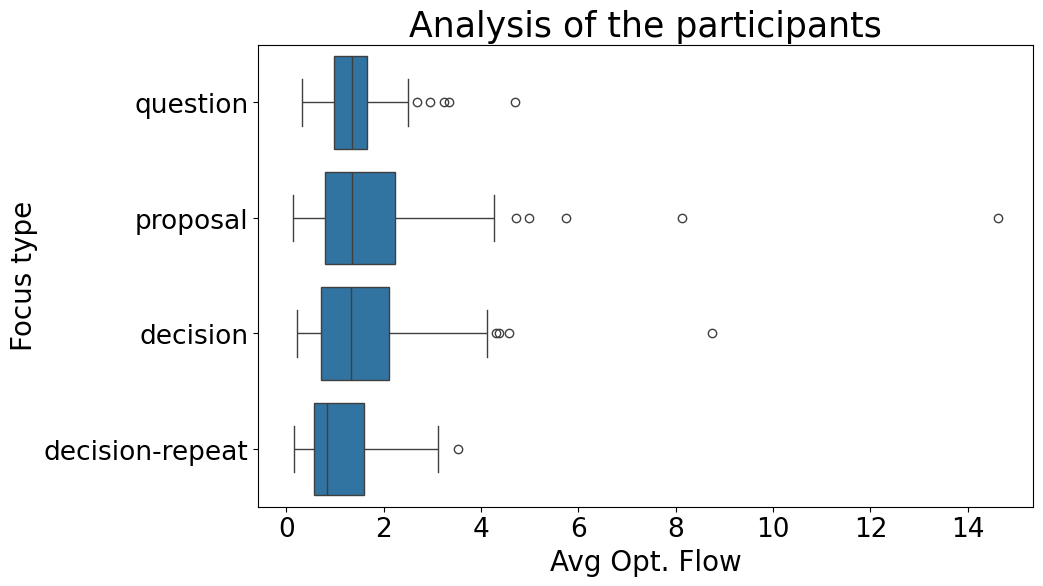

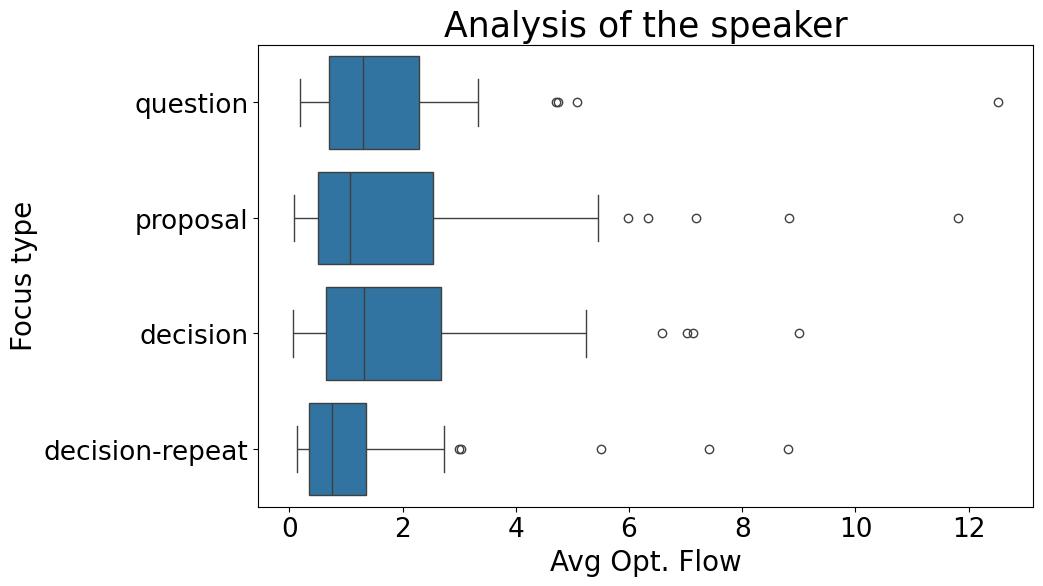

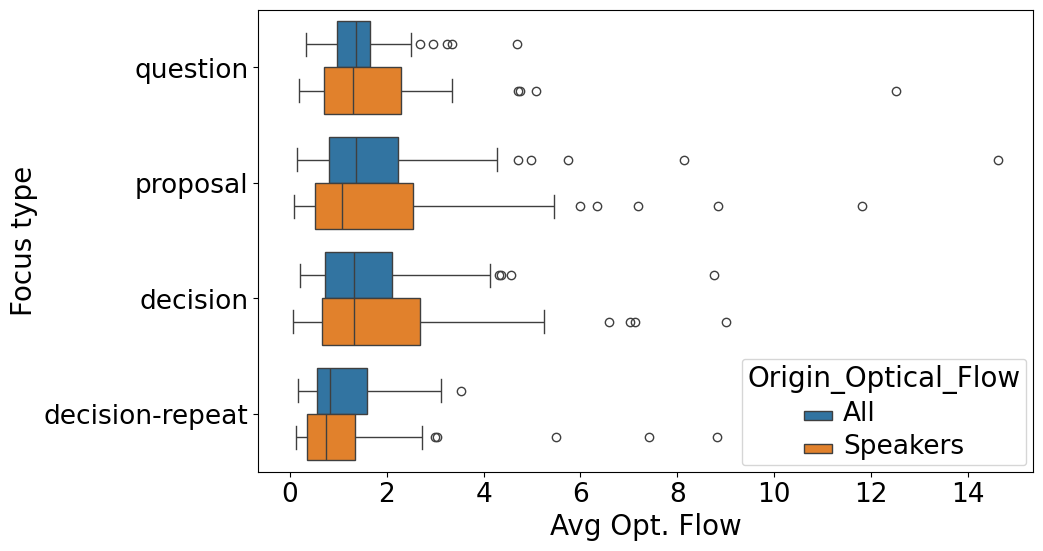

In [21]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 6)
g = sns.boxplot(
    data,
    y = "Type",
    x="AVG_Optical_Flow_All",
    log_scale=False,
    ax=ax,
)
ax.set_xlabel("Avg Opt. Flow", fontsize=20)
ax.set_ylabel("Focus type", fontsize=20)
ax.tick_params(axis="both", which="major", labelsize=19)
ax.tick_params(axis="both", which="minor", labelsize=19)
ax.set_title("Analysis of the participants", fontsize="25")
plt.show(g)


fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 6)
g = sns.boxplot(
    data,
    y = "Type",
    x="AVG_Optical_Flow_Speakers",
    log_scale=False,
    ax=ax,
)
ax.set_xlabel("Avg Opt. Flow", fontsize=20)
ax.set_ylabel("Focus type", fontsize=20)
ax.tick_params(axis="both", which="major", labelsize=19)
ax.tick_params(axis="both", which="minor", labelsize=19)
ax.set_title("Analysis of the speaker", fontsize="25")
plt.show(g)


fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 6)
g = sns.boxplot(
    data_melted,
    y = "Type",
    x = "AVG_Optical_Flow",
    hue = "Origin_Optical_Flow",
    log_scale=False,
    ax=ax,
)
ax.set_xlabel("Avg Opt. Flow", fontsize=20)
ax.set_ylabel("Focus type", fontsize=20)
ax.tick_params(axis="both", which="major", labelsize=19)
ax.tick_params(axis="both", which="minor", labelsize=19)
plt.setp(ax.get_legend().get_texts(), fontsize="19")  # for legend text
plt.setp(ax.get_legend().get_title(), fontsize="20")  # for legend title
plt.show(g)

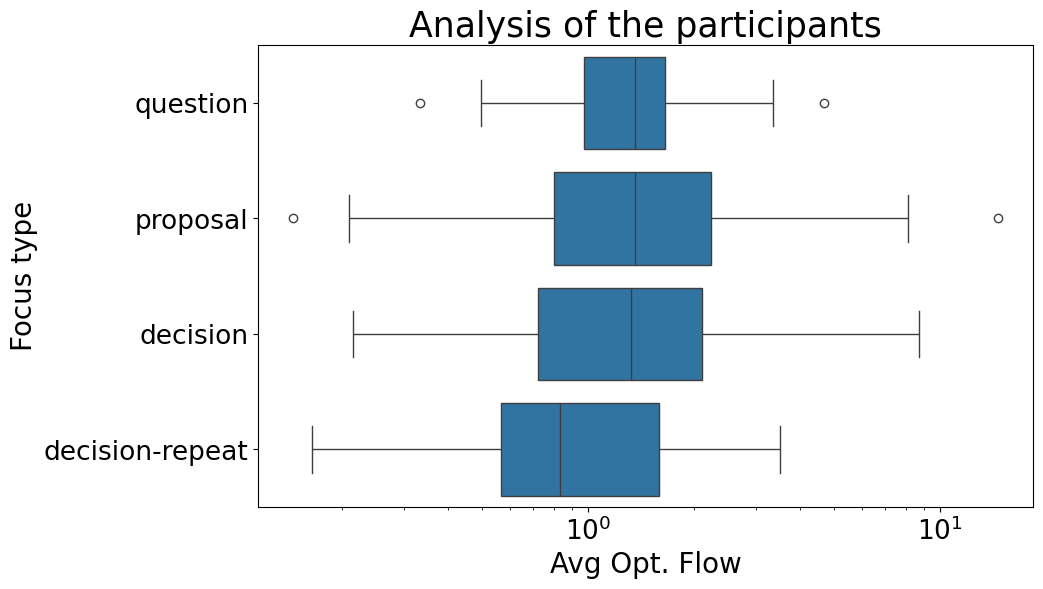

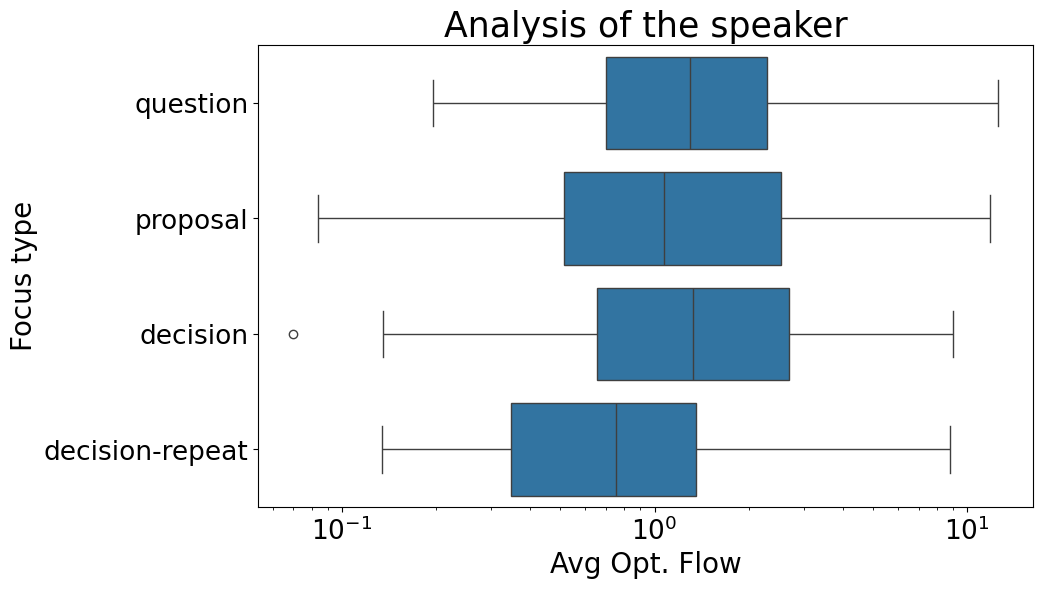

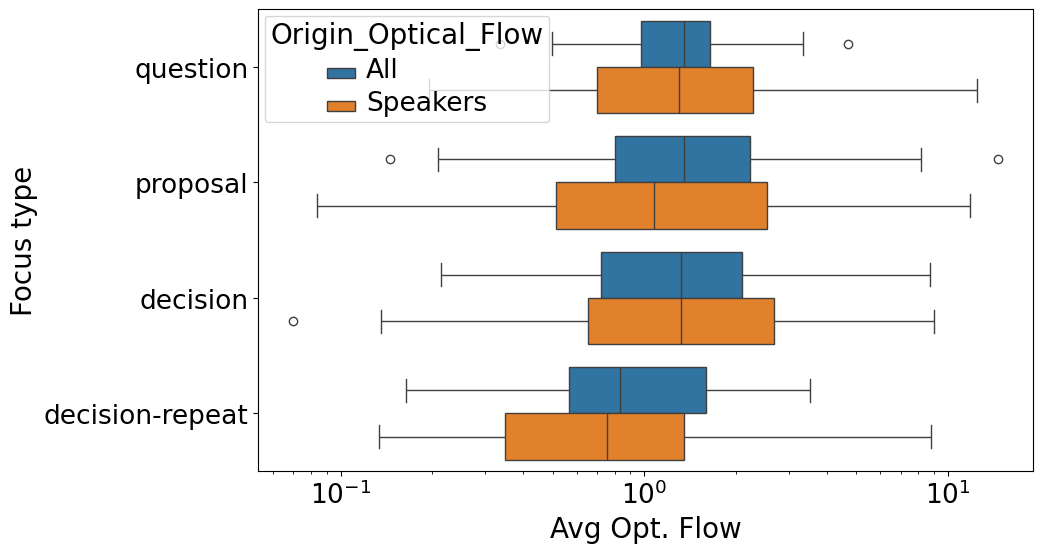

In [22]:
# Plot in log scale

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 6)
g = sns.boxplot(
    data,
    y = "Type",
    x="AVG_Optical_Flow_All",
    log_scale=True,
    ax=ax,
)
ax.set_xlabel("Avg Opt. Flow", fontsize=20)
ax.set_ylabel("Focus type", fontsize=20)
ax.tick_params(axis="both", which="major", labelsize=19)
ax.tick_params(axis="both", which="minor", labelsize=19)
ax.set_title("Analysis of the participants", fontsize="25")
plt.show(g)


fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 6)
g = sns.boxplot(
    data,
    y = "Type",
    x="AVG_Optical_Flow_Speakers",
    log_scale=True,
    ax=ax,
)
ax.set_xlabel("Avg Opt. Flow", fontsize=20)
ax.set_ylabel("Focus type", fontsize=20)
ax.tick_params(axis="both", which="major", labelsize=19)
ax.tick_params(axis="both", which="minor", labelsize=19)
ax.set_title("Analysis of the speaker", fontsize="25")
plt.show(g)


fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 6)
g = sns.boxplot(
    data_melted,
    y = "Type",
    x = "AVG_Optical_Flow",
    hue = "Origin_Optical_Flow",
    log_scale=True,
    ax=ax,
)
ax.set_xlabel("Avg Opt. Flow", fontsize=20)
ax.set_ylabel("Focus type", fontsize=20)
ax.tick_params(axis="both", which="major", labelsize=19)
ax.tick_params(axis="both", which="minor", labelsize=19)
plt.setp(ax.get_legend().get_texts(), fontsize="19")  # for legend text
plt.setp(ax.get_legend().get_title(), fontsize="20")  # for legend title
plt.show(g)

In [23]:
data_log = data.copy()
data_log["AVG_Optical_Flow_Speakers"] = np.log(data_log["AVG_Optical_Flow_Speakers"])
data_log["AVG_Optical_Flow_All"] = np.log(data_log["AVG_Optical_Flow_All"])
data_log[["Type", "AVG_Optical_Flow_All", "AVG_Optical_Flow_Speakers"]].groupby("Type").describe()

AVG_Optical_Flow_All                                          \
                               count      mean       std       min       25%   
Type                                                                           
decision                        75.0  0.229036  0.808414 -1.538515 -0.326904   
decision-repeat                 40.0 -0.113778  0.733667 -1.807841 -0.568090   
proposal                       179.0  0.273137  0.749276 -1.927839 -0.218919   
question                        35.0  0.253599  0.572557 -1.096306 -0.027410   

                                              AVG_Optical_Flow_Speakers  \
                      50%       75%       max                     count   
Type                                                                      
decision         0.282762  0.745148  2.169282                      75.0   
decision-repeat -0.180575  0.467460  1.259781                      40.0   
proposal         0.305094  0.803273  2.682132                     179.0   
question         0.306113  0.503283  1.546441                      35.0   

                                                                             \
                     mean       std       min       25%       50%       75%   
Type                                                                          
decision         0.246163  0.998241 -2.660929 -0.423901  0.283175  0.987376   
decision-repeat -0.254696  1.033582 -2.007701 -1.054613 -0.284540  0.302864   
proposal         0.092837  1.017381 -2.479288 -0.665857  0.071758  0.930150   
question         0.206717  0.916495 -1.630744 -0.355105  0.261029  0.827054   

                           
                      max  
Type                       
decision         2.197392  
decision-repeat  2.176423  
proposal         2.469656  
question         2.526955

## ANOVA (Group by type each meeting)



In [24]:
data_log.head()
data_grouped = data_log[["Session", "Type", "AVG_Optical_Flow_All", "AVG_Optical_Flow_Speakers"]].groupby(["Session", "Type"])
points_anova = data_grouped.mean().reset_index()
types = points_anova.reset_index()["Type"].unique()

# AVG_Optical_Flow_Speakers
points_anova_np = pd.pivot_table(points_anova, index = ["Session"], values = "AVG_Optical_Flow_Speakers", columns = "Type").to_numpy()
points_anova_np = points_anova_np.T # one type per row
points_anova_np

array([[ 0.26002926,  0.54188922,  1.07252311,  0.19669611,  0.44544672,
         0.01932358, -0.86807199],
       [-0.17280899, -1.09690465,  0.53816442,  0.35995568,  0.19745679,
        -0.42935107, -0.45858406],
       [ 0.33931872,  0.21660876,  0.015933  , -0.25136251,  0.48750639,
         0.03539175, -0.69114381],
       [ 0.45576976, -0.80560176,  0.32202964, -0.0450841 ,  0.59473633,
         0.62270147,  0.55574207]])

In [25]:
lists_values = []
for i in range(points_anova_np.shape[0]):
    lists_values.append(list(points_anova_np[i, :]))

stats.f_oneway(*points_anova_np.tolist())

F_onewayResult(statistic=0.9244160960219433, pvalue=0.44404190095311835)

With a p-value of 0.444 we cannot reject the null hypothesis that the differences are no more than random variability.

## Mixed effects model

In [26]:
data_log

,Session,Method,Start,End,Type,Speakers,AVG_Optical_Flow_All,AVG_Optical_Flow_Speakers
0,SESS001,RAFT,0.780,1.800,question,bl,0.000945,-0.204010
1,SESS001,RAFT,3.840,4.830,proposal,tl-br,1.425251,1.406920
2,SESS001,RAFT,11.070,12.140,proposal,bl,1.366290,1.788827
3,SESS001,RAFT,25.120,26.830,decision,bl,0.286368,0.059109
4,SESS001,RAFT,26.830,30.800,proposal,bl,0.161965,0.142783
...,...,...,...,...,...,...,...,...
324,SESS009,RAFT,469.890,471.190,proposal,bc,-0.700771,-0.225422
325,SESS009,RAFT,517.640,518.760,decision-repeat,tl,1.139767,2.176423
326,SESS009,RAFT,520.780,521.220,decision-repeat,tl,-1.262872,-0.782150
327,SESS009,RAFT,521.220,521.810,decision-repeat,tl,-1.807841,-1.949977


In [27]:

# # In this case it does not converge
# model = smf.mixedlm("AVG_Optical_Flow_Speakers ~ Type",
#                    data_log,
#                    groups=data_log["Session"])
# results = model.fit()
#
#  # Results
# print(results.summary())
# print(model.score(results.params_object))


model = smf.mixedlm("AVG_Optical_Flow_All ~ Type",
                    data_log,
                    groups=data_log["Session"])
results = model.fit()

# Results
print(results.summary())
model.score(results.params_object) # print the gradiet to check if converged (10^-2 ok)



              Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: AVG_Optical_Flow_All
No. Observations: 329     Method:             REML                
No. Groups:       7       Scale:              0.4142              
Min. group size:  37      Log-Likelihood:     -335.5613           
Max. group size:  62      Converged:          Yes                 
Mean group size:  47.0                                            
------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept                0.246    0.182  1.351 0.177 -0.111  0.604
Type[T.decision-repeat] -0.227    0.130 -1.755 0.079 -0.481  0.027
Type[T.proposal]        -0.020    0.090 -0.229 0.819 -0.196  0.155
Type[T.question]        -0.055    0.132 -0.416 0.678 -0.315  0.205
Group Var                0.194    0.185                           



array([-0.00024385])